In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization:** The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape:** The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [2]:
# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


# Build Generator

### This generator is part of a CGAN that generates images according to the given label.

### It combines random noise with a label to create a specific image class (e.g., generating a "2" when the label is 2).

In [3]:
# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()
build_generator().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1000      ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 100)                  0         ['embedding_1[0][0]']         
                                                                                            

# Build Discriminator Model

### This model is a discriminator in a CGAN. It takes both an image and a label as input and determines whether the image is real or fake, based on the given label.

### By combining the image and label inputs, the discriminator can ensure that the image corresponds to the specified label before deciding if it's real or fake.

In [4]:
# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build the discriminator and print the summary
discriminator = build_discriminator()
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 784)               7840      ['input_6[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['embedding_2[0][0]']         
                                                                                                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                            

# Build and Compile the Models

### The **discriminator** is compiled with the Adam optimizer and binary cross-entropy loss since it needs to classify whether the input is real or fake (binary classification). The accuracy metric is also tracked.

### The **GAN** model is created by combining the generator and discriminator. It takes random noise and a label as input, generates an image, and then passes that image (along with the label) to the discriminator to check if it's real or fake.

### The GAN is also compiled with binary cross-entropy loss since it still involves distinguishing between real and fake images.

In [5]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the Function

### Two arrays, real and fake, are created to represent the target labels: 1 for real images and 0 for fake images.

### The loop runs for a specified number of epochs, where a random batch of real images and their corresponding labels is selected from the dataset for each iteration.

### **Random noise** is generated and fed into the generator (along with the labels) to create fake images.

### The **discriminator** is trained on both the real images (with label 1) and the generated (fake) images (with label 0). The final loss for the discriminator is the average of the two losses.

### The generator is trained through the GAN by trying to fool the discriminator into thinking the generated images are real. The target labels for this are 1 (real) because the generator is rewarded when it can make the discriminator believe its images are real.

# Question 01

## **Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').**

In [6]:
def train(epochs, digits_to_generate, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Get indices for the specific digits (e.g., '7' and '9')
    digit_indices_7 = np.where(Y_train == digits_to_generate[0])[0]
    digit_indices_9 = np.where(Y_train == digits_to_generate[1])[0]
    digit_indices = np.concatenate([digit_indices_7, digit_indices_9])

    for epoch in range(epochs):
        # Randomly choose real images of either '7' or '9'
        idx = np.random.choice(digit_indices, batch_size)
        real_images = X_train[idx]
        labels = Y_train[idx]

        # Generate random noise and fake labels (either '7' or '9')
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (through the combined GAN model)
        g_loss = gan.train_on_batch([noise, labels], real)

        # Print the progress
        print(f"Epoch {epoch+1} / {epochs}")

        if epoch % save_interval == 0:
            loss = f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]"
            print(loss)
            save_images(epoch, digits_to_generate,loss)

# Saving Generated Images

### This function generates and saves images at each specified interval. It generates 10 images (for digits 0-9) by feeding random noise and the corresponding labels into the generator.

### The images are rescaled from the range [-1, 1] to [0, 1] for display. A 2x5 grid of images is created and displayed.

2/2 [==============================] - 0s 6ms/step
Epoch 1 / 2000
0 [D loss: 0.6656799018383026, acc.: 34.375%] [G loss: 0.7151246070861816]
1/1 [==============================] - 0s 118ms/step


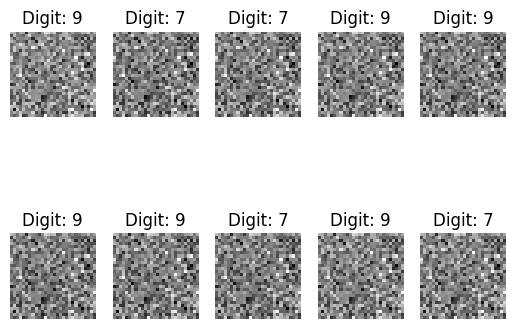

2/2 [==============================] - 0s 5ms/step
Epoch 2 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 3 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 4 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 5 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 6 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 7 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 8 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 9 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 10 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 11 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 12 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 13 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 14 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 15 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 16 / 2000
2/2

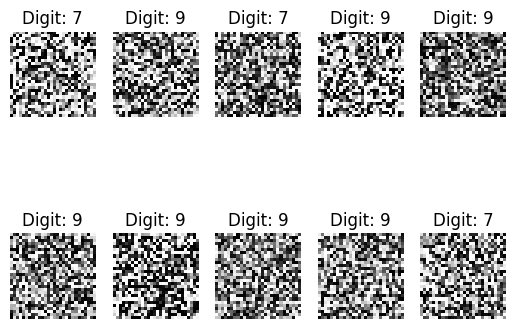

2/2 [==============================] - 0s 5ms/step
Epoch 102 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 103 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 104 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 105 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 106 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 107 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 108 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 109 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 110 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 111 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 112 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 113 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 114 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 115 / 2000
2/2 [==============================] - 0s 5ms/st

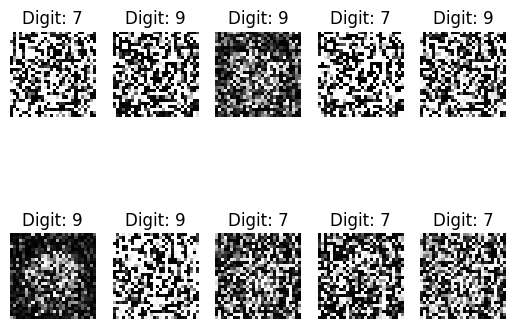

2/2 [==============================] - 0s 5ms/step
Epoch 202 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 203 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 204 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 205 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 206 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 207 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 208 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 209 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 210 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 211 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 212 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 213 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 214 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 215 / 2000
2/2 [==============================] - 0s 5ms/st

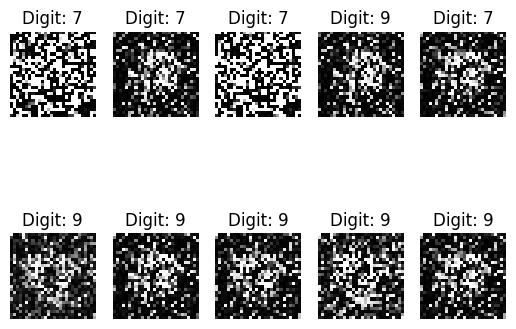

2/2 [==============================] - 0s 5ms/step
Epoch 302 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 303 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 304 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 305 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 306 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 307 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 308 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 309 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 310 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 311 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 312 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 313 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 314 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 315 / 2000
2/2 [==============================] - 0s 5ms/st

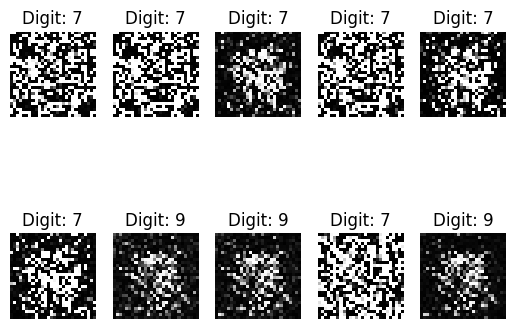

2/2 [==============================] - 0s 5ms/step
Epoch 402 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 403 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 404 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 405 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 406 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 407 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 408 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 409 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 410 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 411 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 412 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 413 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 414 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 415 / 2000
2/2 [==============================] - 0s 5ms/st

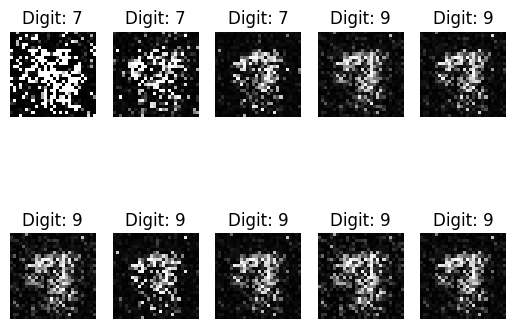

2/2 [==============================] - 0s 5ms/step
Epoch 502 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 503 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 504 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 505 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 506 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 507 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 508 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 509 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 510 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 511 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 512 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 513 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 514 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 515 / 2000
2/2 [==============================] - 0s 5ms/st

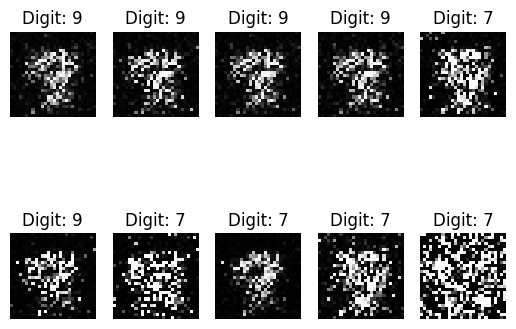

2/2 [==============================] - 0s 5ms/step
Epoch 602 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 603 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 604 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 605 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 606 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 607 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 608 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 609 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 610 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 611 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 612 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 613 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 614 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 615 / 2000
2/2 [==============================] - 0s 5ms/st

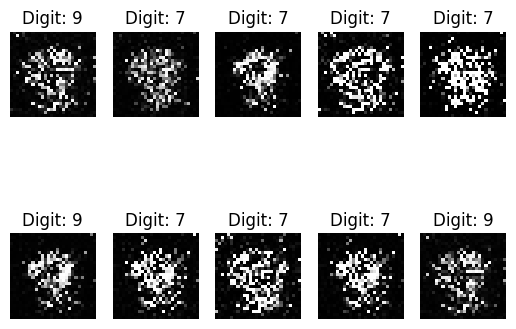

2/2 [==============================] - 0s 5ms/step
Epoch 702 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 703 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 704 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 705 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 706 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 707 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 708 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 709 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 710 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 711 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 712 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 713 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 714 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 715 / 2000
2/2 [==============================] - 0s 5ms/st

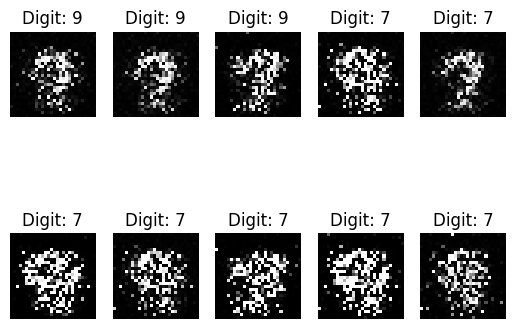

2/2 [==============================] - 0s 5ms/step
Epoch 802 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 803 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 804 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 805 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 806 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 807 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 808 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 809 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 810 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 811 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 812 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 813 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 814 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 815 / 2000
2/2 [==============================] - 0s 4ms/st

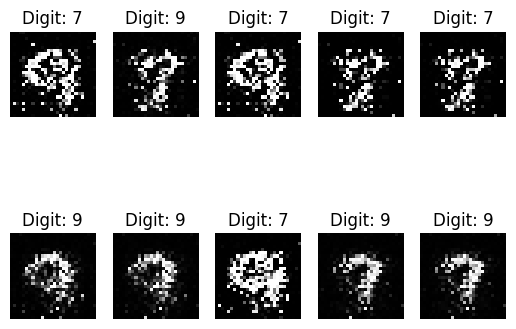

2/2 [==============================] - 0s 5ms/step
Epoch 902 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 903 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 904 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 905 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 906 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 907 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 908 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 909 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 910 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 911 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 912 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 913 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 914 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 915 / 2000
2/2 [==============================] - 0s 5ms/st

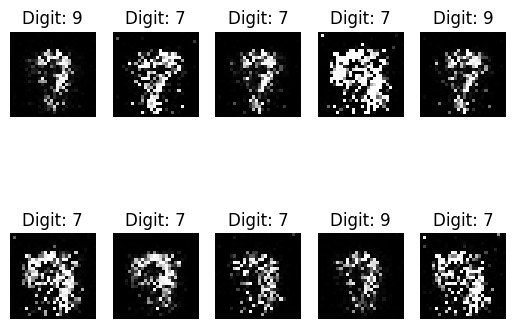

2/2 [==============================] - 0s 5ms/step
Epoch 1002 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1003 / 2000
2/2 [==============================] - 0s 6ms/step
Epoch 1004 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1005 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1006 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1007 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1008 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1009 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1010 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1011 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1012 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1013 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1014 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1015 / 2000
2/2 [=============================

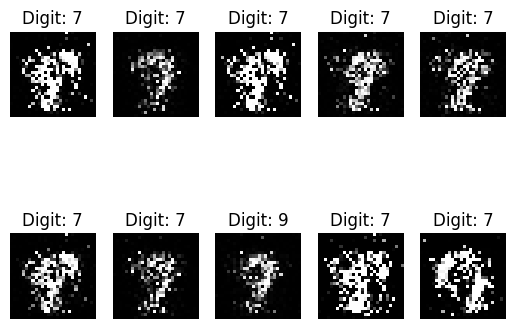

2/2 [==============================] - 0s 5ms/step
Epoch 1102 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1103 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1104 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1105 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1106 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1107 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1108 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1109 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1110 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1111 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1112 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1113 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1114 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1115 / 2000
2/2 [=============================

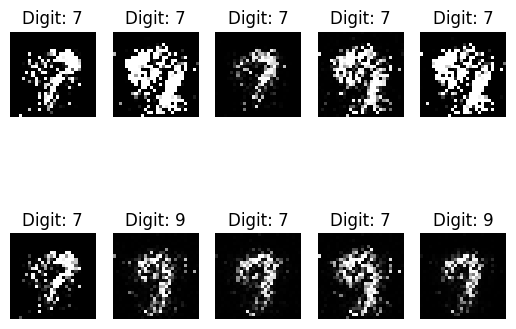

2/2 [==============================] - 0s 5ms/step
Epoch 1202 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1203 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1204 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1205 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1206 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1207 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1208 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1209 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1210 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1211 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1212 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1213 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1214 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1215 / 2000
2/2 [=============================

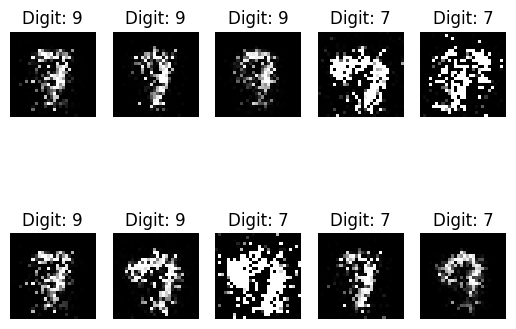

2/2 [==============================] - 0s 5ms/step
Epoch 1302 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1303 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1304 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1305 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1306 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1307 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1308 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1309 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1310 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1311 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1312 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1313 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1314 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1315 / 2000
2/2 [=============================

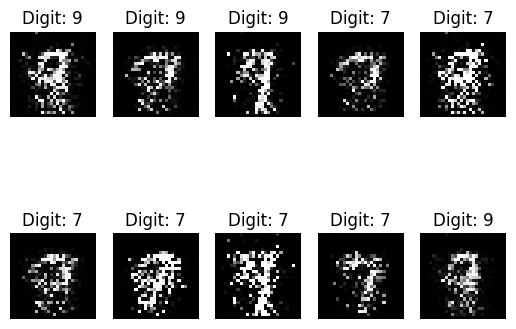

2/2 [==============================] - 0s 5ms/step
Epoch 1402 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1403 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1404 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1405 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1406 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1407 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1408 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1409 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1410 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1411 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1412 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1413 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1414 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1415 / 2000
2/2 [=============================

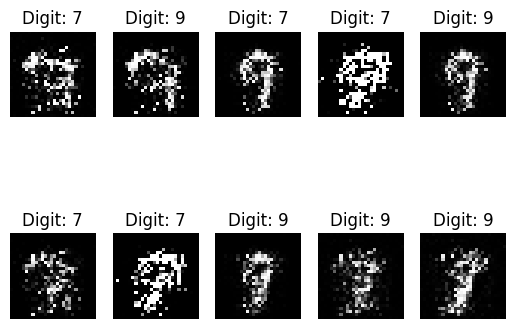

2/2 [==============================] - 0s 5ms/step
Epoch 1502 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1503 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1504 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1505 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1506 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1507 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1508 / 2000
2/2 [==============================] - 0s 7ms/step
Epoch 1509 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1510 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1511 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1512 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1513 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1514 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1515 / 2000
2/2 [=============================

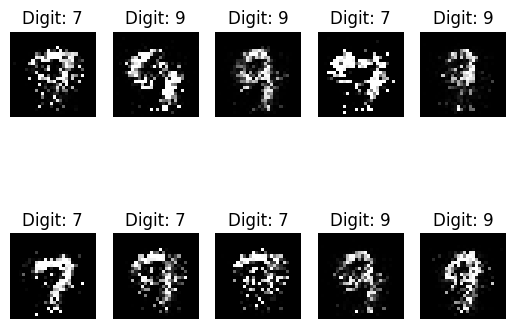

2/2 [==============================] - 0s 6ms/step
Epoch 1602 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1603 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1604 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1605 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1606 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1607 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1608 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1609 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1610 / 2000
2/2 [==============================] - 0s 6ms/step
Epoch 1611 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1612 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1613 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1614 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1615 / 2000
2/2 [=============================

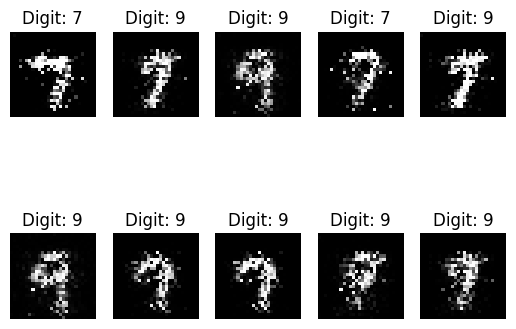

2/2 [==============================] - 0s 5ms/step
Epoch 1702 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1703 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1704 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1705 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1706 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1707 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1708 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1709 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1710 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1711 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1712 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1713 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1714 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1715 / 2000
2/2 [=============================

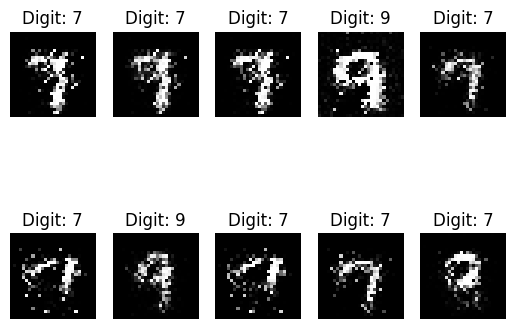

2/2 [==============================] - 0s 5ms/step
Epoch 1802 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1803 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1804 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1805 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1806 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1807 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1808 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1809 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1810 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1811 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1812 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1813 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1814 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1815 / 2000
2/2 [=============================

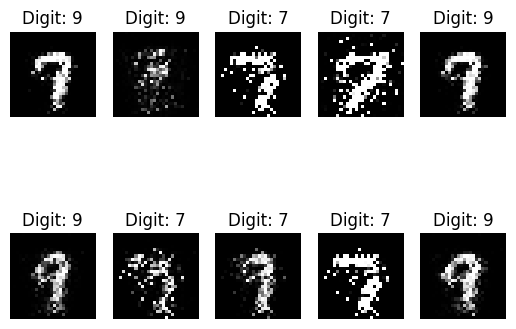

2/2 [==============================] - 0s 5ms/step
Epoch 1902 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1903 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1904 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1905 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1906 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1907 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1908 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1909 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1910 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1911 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1912 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1913 / 2000
2/2 [==============================] - 0s 4ms/step
Epoch 1914 / 2000
2/2 [==============================] - 0s 5ms/step
Epoch 1915 / 2000
2/2 [=============================

In [7]:
import os
# Modify save_images function to display images of either '7' or '9'
def save_images(epoch, digits_to_generate,loss):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))

    # Randomly select labels (either '7' or '9') for generation
    labels = np.random.choice(digits_to_generate, r * c).reshape(-1, 1)

    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

      # Create directory if it doesn't exist
    if not os.path.exists('7-8-gen-images-cgan'):
        os.makedirs('7-8-gen-images-cgan')

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt][0]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    fig.savefig(f"7-8-gen-images-cgan/epoch_{epoch}_loss{loss}.png")
    plt.close()

# Train the CGAN to generate either '7' or '9'
train(epochs=2000, digits_to_generate=[7, 9], batch_size=64, save_interval=100)

In [8]:
import shutil
import os
from google.colab import files

directory_name = '7-8-gen-images-cgan'

# Check if the directory exists
if os.path.exists(directory_name):
    # Create a zip file of the directory
    shutil.make_archive(directory_name, 'zip', directory_name)

    # Download the zip file
    files.download(f"{directory_name}.zip")
else:
    print(f"Directory {directory_name} does not exist!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

# Question 02

## **Add label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images.**





In [9]:
# Training function with label smoothing
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Smooth the labels for real images
        real_smooth = real - 0.1 * np.random.random(real.shape)

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        labels_real = Y_train[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        labels_fake = np.random.randint(0, 10, batch_size)  # Random labels for generated images
        fake_images = generator.predict([noise, labels_fake])

        # Train the discriminator (real labeled images, smoothed labels)
        d_loss_real = discriminator.train_on_batch([real_images, labels_real], real_smooth)

        # Train the discriminator (fake labeled images)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels_fake], fake)

        # Average the discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (with real labels to "fool" the discriminator)
        g_loss = gan.train_on_batch([noise, labels_fake], real)

        # Output the training progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, d_loss[0])

2/2 [==============================] - 0s 6ms/step
0 [D loss: 13.19903177022934, acc.: 10.15625%] [G loss: 3.4616518020629883]
1/1 [==============================] - 0s 26ms/step


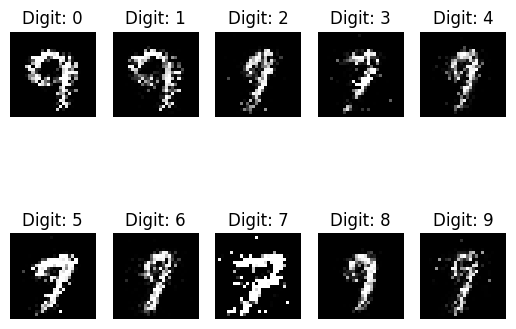

2/2 [==============================] - 0s 5ms/step
100 [D loss: 0.34961096942424774, acc.: 47.65625%] [G loss: 2.0685243606567383]
1/1 [==============================] - 0s 28ms/step


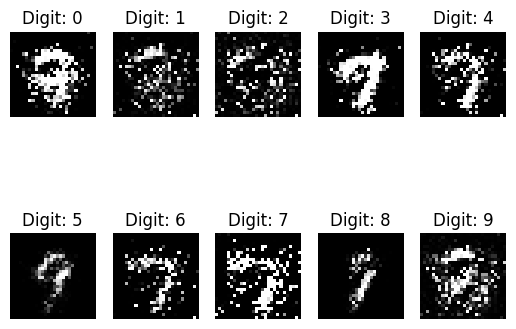

2/2 [==============================] - 0s 5ms/step
200 [D loss: 0.2524293065071106, acc.: 50.0%] [G loss: 3.2714462280273438]
1/1 [==============================] - 0s 27ms/step


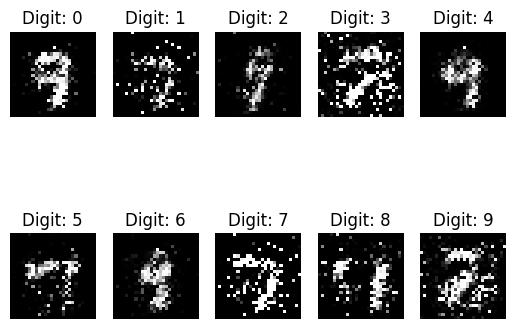

2/2 [==============================] - 0s 5ms/step
300 [D loss: 0.2705100476741791, acc.: 49.21875%] [G loss: 2.7818551063537598]
1/1 [==============================] - 0s 25ms/step


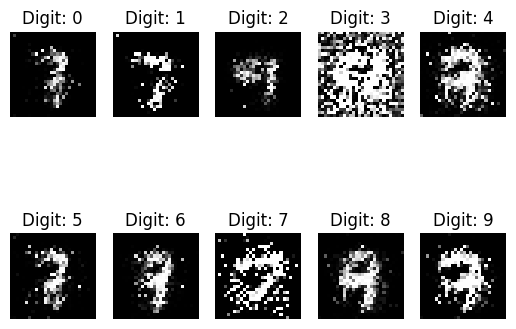

2/2 [==============================] - 0s 5ms/step
400 [D loss: 0.29918043315410614, acc.: 46.875%] [G loss: 2.630016326904297]
1/1 [==============================] - 0s 26ms/step


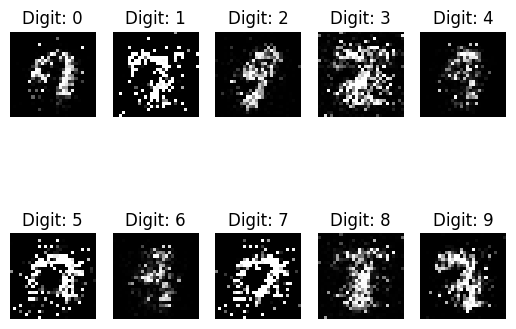

2/2 [==============================] - 0s 5ms/step
500 [D loss: 0.29459287971258163, acc.: 49.21875%] [G loss: 3.0038137435913086]
1/1 [==============================] - 0s 26ms/step


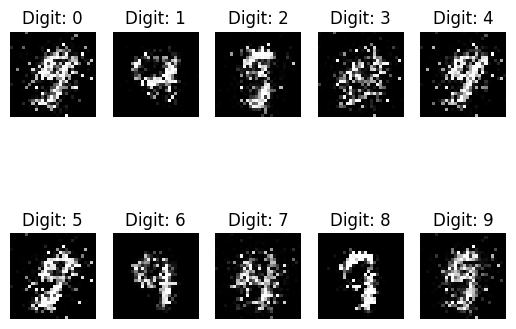

2/2 [==============================] - 0s 5ms/step
600 [D loss: 0.21645748615264893, acc.: 46.875%] [G loss: 4.213014125823975]
1/1 [==============================] - 0s 25ms/step


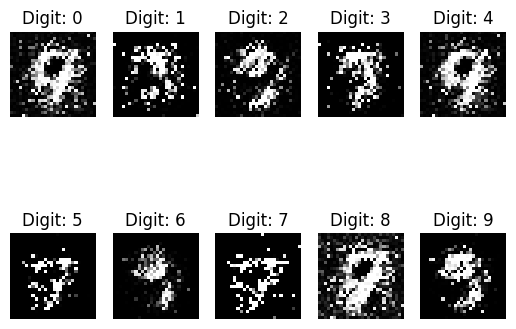

2/2 [==============================] - 0s 4ms/step
700 [D loss: 0.24031136184930801, acc.: 49.21875%] [G loss: 4.74077844619751]
1/1 [==============================] - 0s 25ms/step


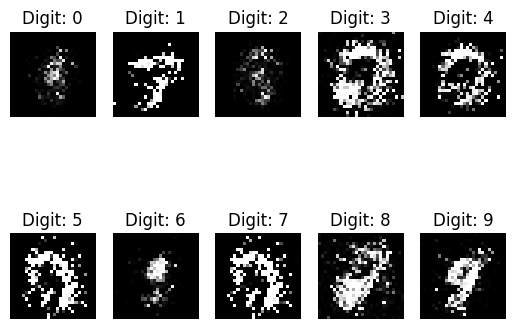

2/2 [==============================] - 0s 5ms/step
800 [D loss: 0.2913655936717987, acc.: 45.3125%] [G loss: 3.6824684143066406]
1/1 [==============================] - 0s 27ms/step


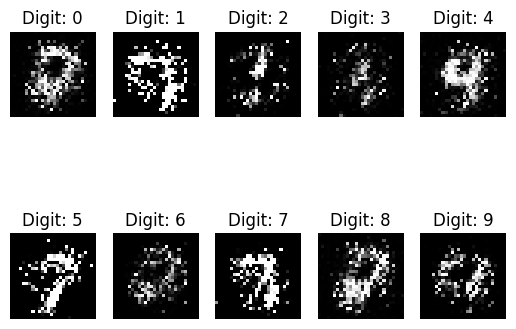

2/2 [==============================] - 0s 5ms/step
900 [D loss: 0.3423638716340065, acc.: 45.3125%] [G loss: 3.3343822956085205]
1/1 [==============================] - 0s 27ms/step


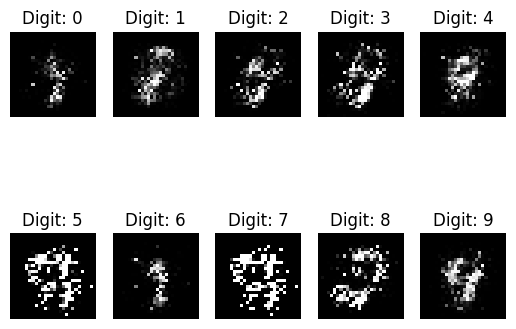

2/2 [==============================] - 0s 5ms/step


In [10]:
import os
# Modify save_images function to display images of either '7' or '9'
def save_images(epoch, digits_to_generate):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    # Create directory if it doesn't exist
    if not os.path.exists('label-smoothing-images-cgan'):
        os.makedirs('label-smoothing-images-cgan')

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    fig.savefig(f"label-smoothing-images-cgan/epoch_{epoch}.png")
    plt.close()

# Train the CGAN to generate either '7' or '9'
train(epochs=1000, batch_size=64, save_interval=100)

In [14]:
import shutil
import os
from google.colab import files

directory_name = 'label-smoothing-images-cgan'

# Check if the directory exists
if os.path.exists(directory_name):
    # Create a zip file of the directory
    shutil.make_archive(directory_name, 'zip', directory_name)

    # Download the zip file
    files.download(f"{directory_name}.zip")
else:
    print(f"Directory {directory_name} does not exist!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label smoothing, a method used to enhance GANs by substituting label values of ‘1’ with some values ranging from ‘0.9’ to ‘1’, assists in avoiding fluctuations while training the GANs. This helps to reduce the overfitting potential of the discriminator and encourage that the discriminator feeds back more useful gradients to the generator. This allows the generator to be capable of creating high quality and variety of images and further improve the training dynamics and mitigation of mode collapse problem. In turn, label smoothing increases the quality of the outputs and makes the convergence in the training faster as well.

---



# Question 03

## **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**

1/1 [==============================] - 0s 28ms/step


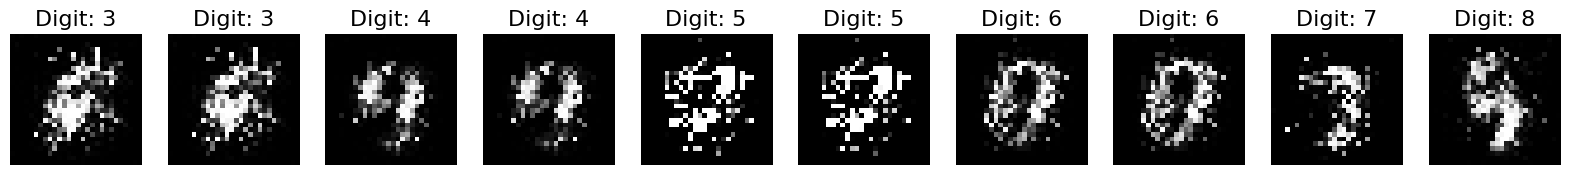

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noise vectors for digits '3' and '8'
noise_digit_3 = np.random.normal(0, 1, (1, 100))
label_digit_3 = np.array([3]).reshape(-1, 1)

noise_digit_8 = np.random.normal(0, 1, (1, 100))
label_digit_8 = np.array([8]).reshape(-1, 1)

# Perform linear interpolation between the two noise vectors
num_steps = 10
interpolation_steps = np.linspace(0, 1, num_steps)
interpolated_noises = [(1 - alpha) * noise_digit_3 + alpha * noise_digit_8 for alpha in interpolation_steps]

# Generate images for each interpolated noise vector
generated_images = []
for alpha, noise in zip(interpolation_steps, interpolated_noises):
    # Calculate the corresponding label for the interpolation
    label = np.array([int(3 * (1 - alpha) + 8 * alpha)]).reshape(-1, 1)  # Interpolating labels as well
    generated_image = generator.predict([noise, label])
    generated_images.append(generated_image)

# Rescale images to [0, 1] for display
generated_images = [0.5 * img + 0.5 for img in generated_images]

# Visualize the interpolation process
fig, axs = plt.subplots(1, num_steps, figsize=(20, 5))

for i in range(num_steps):
    axs[i].imshow(generated_images[i][0, :, :, 0], cmap='gray')
    axs[i].axis('off')
    # Add labels for each step
    # Interpolate label for the title
    interpolated_label = int(3 * (1 - interpolation_steps[i]) + 8 * interpolation_steps[i])
    axs[i].set_title(f"Digit: {interpolated_label}", fontsize=16)

plt.show()